# <img src="assets/ufscar.png" alt="Logo UFScar" width="200" align="left"/><p><center>Universidade Federal de São Carlos (UFSCar)</center><br/><font size="4"><center> Departamento de Computação, campus Sorocaba </center> </font>


<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>
</p>

<br>
<font size = "4"><center><b> Grupo 5: Análise de sentimento de reviews na Amazon </b></center></font>
<br>

# KNN - K Nearest Neighbors

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pre_processing as pp
import analysis as anl
import pca

# Categoria da base de dados a ser lida (do disco) e processada
# [books, kitchen_&_housewares, electronics, dvd, all]
category = 'test'

# Se positivo, adiciona bigramas para reviews negativas
# ex: ('not', 'good') equivale a uma única feature
hNeg = True

# Se positivo, adiciona substantivos
noun = False

# Guarda as features ja processadas em X, a classe da amostra em Y e o vocabulario em vocabulary
# hNeg e noun sao opcionais, por padrao hNeg=True, noun=False
X, Y, vocabulary = pp.bow(category, hNeg, noun)

print("Vocabulário possui " + str(len(vocabulary)) + " palavras!")

Vocabulário possui 1509 palavras!


#### Função auxiliar para normalizar os dados:

In [2]:
def normalizar(X):

    m, n = X.shape # m = qtde de objetos e n = qtde de atributos por objeto
    
    # Inicializa as variaveis de saida
    X_norm = np.zeros( (m,n) ) #inicializa X_norm (base normalizada)

    mu = 0 # inicializa a media
    sigma = 1 # inicializa o desvio padrao
      
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    
    for i in range(m):
        for j in range(n):
            X_norm[i][j] = (X[i][j] - mu[j])/(sigma[j])
        
    return X_norm

#### Separa os dados em treinamento e teste:

In [3]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X2, Y2 = X[idx_perm, :], Y[idx_perm]

# Porcentagem de amostras destinadas a base de treino
pTrain = 0.8

# Executa o holdout e retorna os indices de treino e teste, mantendo a proporcao original entre as classes
train_index, test_index = anl.stratified_holdOut(Y, pTrain)

# Guarda as amostras de treino e teste
Xtrain, Xval = X2[train_index, :], X2[test_index, :]
Ytrain, Yval = Y2[train_index], Y2[test_index]

#### Seleciona features com chi-quadrado (a partir dos dados de treinamento):

In [4]:
# Seta o valor de alpha para o chi-quadrado. 
# alpha e opcional, por padrão alpha = 0.05
alpha = 0.05

# Chama a funcao para executar o chi-quadrado e retorna a nova base de dados reduzida
# o novo vocabulario e os indices das features mantidas
Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary, alpha)

# Seleciona apenas as features do indice retornado pelo chi-quadrado para a base de teste
Xval = Xval[:, index]

# Converte as bases de matriz esparsa para array
Xtrain = Xtrain.toarray()
Xval = Xval.toarray()

In [5]:
print("Número de features antes do chi-quadrado: " + str(len(vocabulary)))
print("----------------------------------------")
print("Número de features após chi-quadrado: " + str(len(new_vocabulary)))
print(new_vocabulary)

Número de features antes do chi-quadrado: 1509
----------------------------------------
Número de features após chi-quadrado: 26
['arab', 'true', 'pain', 'wast', 'written', 'love', 'hormon', 'mean', 'less', 'wish', 'well', 'said', 'legal', 'entir', 'tri', 'whole', 'bad', 'explain', 'die', 'heal', 'horribl', 'good', 'not', 'wild', 'eat', 'paleolith']


#### Função auxiliar para calcular as distâncias de uma amostra x à base X:

In [6]:
def distancia(x, X):
    
    # m = numero de amostras da base X
    m = X.shape[0] 
    
    # Inicializa variavel para guardas as distancias, que sera retornada pela funcao
    D = np.zeros(m) 

    i = 0
    
    # Para cada amostra em X, calcula a distancia para x e guarda em D[i]
    for amostra in X:
        D[i] = np.linalg.norm(amostra - x)
        i += 1
             
            
    return D

#### Implementação do KNN:

In [7]:
def knn(x, X, Y, K):
    
    # Inicializa a variavel de retorno (classe predita da amostra)
    y = 0 
    
    # Inicializa vetor para guardar os indices dos k vizinhos mais proximos
    ind_viz = np.ones(K, dtype=int)
    
    # Guarda as distancias de cada amostra da base X para a amostra x
    D = distancia(x, X)
    
    # Vetor com as classes da base, que recebera os votos 
    votos = np.zeros(len(set(Y)))

    # Guarda os indices dos k vizinhos mais próximos
    ind_viz = np.argsort(D)[:K]
    
    # Para cada amostra nos vizinhos mais proximos, acrescenta um voto para a classe pertencente
    for indice in ind_viz:
        votos[Y[indice]] += 1 
        
    # A classe que tiver mais votos e a escolhida para a predição
    y = np.argmax(votos)
        
    return y

#### Função auxiliar para predizer um conjunto de amostras:

In [8]:
def predicao(K, Xtrain, Ytrain, Xval, Yval):
    
    # Inicializa a variavel de retorno, com as predicoes para cada amostra
    Ypred = []

    # Executa o KNN para cada amostra e guarda em Ypred
    for i in range(Xval.shape[0]):
        y = knn(Xval[i], Xtrain, Ytrain, K)
        Ypred.append(y)
        
    # Calcula a acuracia da predição para o conjunto Xval    
    acuracia = np.sum(Ypred==Yval)/len(Yval)
    
    return Ypred, acuracia

## Curva de Aprendizado:

In [9]:
def curva_aprendizado(X, Y, Xval, Yval, k = 1, num_iteracoes = 0):
   
    """
    Funcao usada gerar a curva de aprendizado.
  
    Parametros
    ----------
  
    X : matriz com os dados de treinamento
  
    Y : vetor com as classes dos dados de treinamento
  
    Xval : matriz com os dados de validação
  
    Yval : vetor com as classes dos dados de validação
    
    k : escalar indicando o numero de vizinhos
    
    num_iteracoes : escalar indicando a quantidade de iteracoes
  
    """

    # Define a quantidade de iteracoes, por padrao, itera por cada amostra da base de treino
    if (num_iteracoes <= 0 or num_iteracoes > len (Y)):
        num_iteracoes = len (Y)
    
    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []

    # Guarda a quantidade de classes da base
    classes = np.unique(Y)
    
    # Itera e executa o KNN com i amostras da base de treino para cada iteracao
    for i in range(10, len(Y), int (len(Y)/num_iteracoes)):
        
        Ypred, acuracia = predicao(k, X[:i], Y[:i], X[:i], Y[:i])
        
        # Guarda a acuracia da iteracao usando a base de treino como teste
        perf_train.append(acuracia)

        Ypred, acuracia = predicao(k, X[:i], Y[:i], Xval, Yval)
        
        # Guarda a acuracia da iteracao usando a base de validacao como teste
        perf_val.append(acuracia)


    ##################################################################################
       
    # Define o tamanho da figura 
    plt.figure(figsize=(20,12))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'Acuracia',fontsize='x-large') 

    # Define o titulo do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()

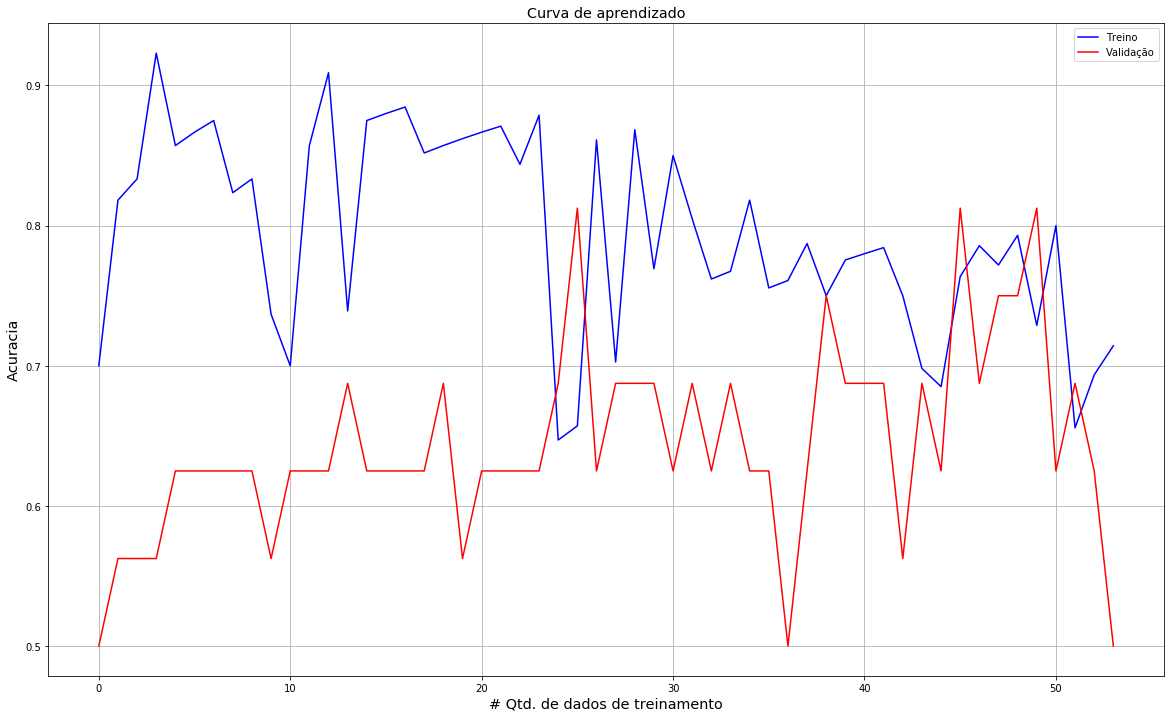

In [10]:
# k = quantidade de vizinhos utilizado na votação do KNN
# num_iteracoes = numero de iterações da curva de aprendizado, por padrao e igual ao numero de amostras da base
curva_aprendizado(Xtrain, Ytrain, Xval, Yval, k = 5, num_iteracoes = 100)

## K-Folds

In [11]:
# Importa o arquivo local k_folds.py
import k_folds as kf

# Guarda todos os tipos de classes 
classes = np.unique(Y)

# semente usada na randomização dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X3, Y3 = X[idx_perm, :], Y[idx_perm]

# Quantidade de Folds a ser executado
nFolds = 5

# Guarda os índices dos nFolds
folds = kf.stratified_kfolds(Y3, nFolds, classes)

# K's a serem testados
K = [3, 5, 7, 9, 11]

for k in K:
    # Apenas para controle das iterações
    kfolds = 1
    
    # Cria uma lista vazia para guardar os resultados obtidos em cada fold
    resultados=[] 
    
    # Itera sobre os folds, guardando os índices de treino e teste
    for train_index, test_index in folds:

        print('\n-----------\n%d-fold: \n-----------\n' % (kfolds) )

        # se train_index ou test_index forem vazios, interrompe o laco de repeticao
        if len(train_index)==0 or len(test_index)==0: 
            print('\tErro: o vetor com os indices de treinamento ou o vetor com os indices de teste esta vazio')      
            break

        # Guarda as bases de treino e teste baseado nos índices de cada fold
        Xtrain, Xtest = X3[train_index, :], X3[test_index, :];
        Ytrain, Ytest = Y3[train_index], Y3[test_index];

        # Executa o chi-quadrado na base do fold atual
        Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary)
        Xtest = Xtest[:,index]

        # Converte as bases para array para serem usadas no KNN
        Xtrain = Xtrain.toarray()
        Xtest = Xtest.toarray()
           
        print("K = " + str(k))
        # Execucao do KNN
        Ypred, acuracia = predicao(k, Xtrain, Ytrain, Xtest, Ytest)
        
        # Relatorio do fold
        auxResults = anl.relatorioDesempenho(Ytest, Ypred, classes, imprimeRelatorio=True)
        
        # Adiciona os resultados do fold atual na lista de resultados
        resultados.append( auxResults )
        
        # Incrementa um na variável de controle do loop
        kfolds += 1
        
    kf.mediaFolds( resultados, classes )
   
       
    


-----------
1-fold: 
-----------

K = 3

	Revocacao   Precisao   F-medida   Classe
	0.000       0.000      nan      0
	0.667       0.429      0.522      1
	------------------------------------------------
	0.333       0.214      0.261      Média macro
	0.353       0.353      0.353      Média micro

	Acuracia: 0.353

-----------
2-fold: 
-----------

K = 3

	Revocacao   Precisao   F-medida   Classe
	0.250       0.333      0.286      0
	0.500       0.400      0.444      1
	------------------------------------------------
	0.375       0.367      0.371      Média macro
	0.375       0.375      0.375      Média micro

	Acuracia: 0.375

-----------
3-fold: 
-----------

K = 3

	Revocacao   Precisao   F-medida   Classe
	0.375       0.600      0.462      0
	0.750       0.545      0.632      1
	------------------------------------------------
	0.562       0.573      0.568      Média macro
	0.562       0.562      0.562      Média micro

	Acuracia: 0.562

-----------
4-fold: 
-----------

K = 3



/home/antonio/Documents/am/analysis.py:54: RuntimeWarning: invalid value encountered in true_divide
  fmedida = 2 * ((precisao * revocacao)/(precisao + revocacao))



	Revocacao   Precisao   F-medida   Classe
	0.125       0.250      0.167      0
	0.625       0.417      0.500      1
	------------------------------------------------
	0.375       0.333      0.353      Média macro
	0.375       0.375      0.375      Média micro

	Acuracia: 0.375

-----------
3-fold: 
-----------

K = 5

	Revocacao   Precisao   F-medida   Classe
	0.750       0.667      0.706      0
	0.625       0.714      0.667      1
	------------------------------------------------
	0.688       0.690      0.689      Média macro
	0.688       0.688      0.688      Média micro

	Acuracia: 0.688

-----------
4-fold: 
-----------

K = 5

	Revocacao   Precisao   F-medida   Classe
	0.500       0.444      0.471      0
	0.375       0.429      0.400      1
	------------------------------------------------
	0.438       0.437      0.437      Média macro
	0.438       0.438      0.438      Média micro

	Acuracia: 0.438

-----------
5-fold: 
-----------

K = 5

	Revocacao   Precisao   F-medida   Clas